# Smart Phishing Email Detector using Deep Learning 

# Import the Neccessary Library

In [ ]:
# Core Libraries
import re
import pickle
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import warnings
import tensorflow as tf
warnings.filterwarnings('ignore')

# NLP & Preprocessing
import nltk
# optional custom path
nltk.data.path.append("C:/nltk_data")  
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# ---- Load Punkt tokenizer manually ----
from nltk.tokenize.punkt import PunktSentenceTokenizer

# ---- Load word tokenizer from treebank manually ----
from nltk.tokenize.treebank import TreebankWordTokenizer

from collections import Counter
from textblob import TextBlob

# Visualization Libraries

from wordcloud import WordCloud

# Scikit-learn Models library

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, classification_report, confusion_matrix

# Classification Report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score ,precision_score, f1_score, recall_score,classification_report,confusion_matrix

# Library needed to build TensorFlow & Keras (Deep Learning)

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Embedding, GRU, LSTM, Bidirectional, SimpleRNN, Dense, Dropout)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model




[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADLIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADLIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Loading

In [17]:
data = pd.read_csv(
    
    "C:/Users/ADLIN/OneDrive/Desktop/DataSets/Phishing.csv",
    encoding='ISO-8859-1',
    engine='python',
    quotechar='"',
    on_bad_lines='skip'  # <-- use this instead of error_bad_lines
)

print(data.head())
print(data.columns)

  Unnamed: 0                                         Email Text  \
0          0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1          1  the other side of * galicismos * * galicismo *...   
2          2  re : equistar deal tickets are you still avail...   
3          3  \nHello I am your hot lil horny toy.\n    I am...   
4          4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  
Index(['Unnamed: 0', 'Email Text', 'Email Type'], dtype='object')


# To describe the data

In [18]:
data['length'] = data['Email Text'].apply(lambda x: len(str(x)))
data["length"].describe()

count     20746.000000
mean       1644.306613
std        3855.906994
min           1.000000
25%         281.000000
50%         745.000000
75%        1680.000000
max      120761.000000
Name: length, dtype: float64

# Data Preprocessing

In [20]:
data.isnull()

,Unnamed: 0,Email Text,Email Type,length
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
20741,False,False,False,False
20742,False,False,False,False
20743,False,False,False,False
20744,False,False,False,False


# To check null values

In [21]:
data.isnull().sum()
data.isna().sum()

Unnamed: 0       0
Email Text    2102
Email Type    2098
length           0
dtype: int64

# To drop the duplicates in the data

In [23]:
# Drop rows where important columns are missing
data.dropna(subset=["Email Text", "Email Type"], inplace=True)

# Drop duplicates
data.drop_duplicates(inplace=True)

# Reset index
data.reset_index(drop=True, inplace=True)



In [ ]:
# To view the shape of the data

data.shape

(18632, 4)

In [ ]:
# To check the duplicated rows

print(data.duplicated())

0        False
1        False
2        False
3        False
4        False
         ...  
18627    False
18628    False
18629    False
18630    False
18631    False
Length: 18632, dtype: bool


In [ ]:
# To print the columns of the DataFrame

print(data.columns)

Index(['Unnamed: 0', 'Email Text', 'Email Type', 'length'], dtype='object')


In [ ]:
# To describe the data
print(data.columns)     
  
# List all available columns
print(data.head())    

Index(['Unnamed: 0', 'Email Text', 'Email Type', 'length'], dtype='object')
  Unnamed: 0                                         Email Text  \
0          0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1          1  the other side of * galicismos * * galicismo *...   
2          2  re : equistar deal tickets are you still avail...   
3          3  \nHello I am your hot lil horny toy.\n    I am...   
4          4  software at incredibly low prices ( 86 % lower...   

       Email Type  length  
0      Safe Email    1030  
1      Safe Email     479  
2      Safe Email    1245  
3  Phishing Email     688  
4  Phishing Email     441  


# To preprocess the data usig NLP

In [ ]:
# To preprocess the text data, we will define a function that removes hyperlinks, punctuation, and unnecessary characters, and converts the text to lowercase.
#We created a word cloud to check the frequency of the words
# We remove all the unnecessary numbers and words to make our dataset more accurate.


def preprocess_text(text):
    # Remove hyperlinks
    text = re.sub(r'http\S+', '', text)
    # Remove punctuations
    text = re.sub(r'[^\w\s]', '', text)

    text = re.sub(r'Â', '', text)

    text = re.sub(r'1/2ï', '', text)

    text = re.sub(r'â', '', text)

    text = re.sub(r'e mail', '', text)

    text = re.sub(r'email', '', text)

    text = re.sub(r'3d', '', text)

    text = re.sub(r'ï', '', text)

    text = re.sub(r'hou ', '', text)

    text = re.sub(r' 000 ', ' ', text)

    text = re.sub(r' e  ', ' ', text)

    text = re.sub(r' 00 ', ' ', text)

    text = re.sub(r' enron ', ' ', text)


    # Convert to lowercase
    text = text.lower()

    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text


# Apply the preprocess_text function to the specified column in the DataFrame
#Converts the "Email Text" column to string format (in case there are NaNs or numbers),


data["Email Text"] =data["Email Text"].apply(preprocess_text)
data.dropna(subset=['Email Text'], inplace=True)


In [ ]:
 # To check the shape of the data

data.shape

(18632, 4)

In [ ]:
# To print the first few rows of the DataFrame

data.head()

,Unnamed: 0,Email Text,Email Type,length
0,0,re 6 1100 disc uniformitarianism re 1086 sex l...,Safe Email,1030
1,1,the other side of galicismos galicismo is a sp...,Safe Email,479
2,2,re equistar deal tickets are you still availab...,Safe Email,1245
3,3,hello i am your hot lil horny toy i am the one...,Phishing Email,688
4,4,software at incredibly low prices 86 lower dra...,Phishing Email,441


# Perform Label Encoding

In [ ]:
# We label the phishing emails as "1" and safe emails as "0" for easier analysis

# Clean and Filter
data['Email Type'] = data['Email Type'].astype(str).str.strip().str.lower()
data = data[data['Email Type'].isin(['safe email', 'phishing email'])]


In [ ]:
# Reset the original labels
data['Email Type'] = data['Email Type'].astype(str).str.strip()

# Encode labels (Phishing = 1, Safe = 0)
lbl = LabelEncoder()
data['Email Type'] = lbl.fit_transform(data['Email Type'])

# See what LabelEncoder did:
print(lbl.classes_)   # Will print something like: ['Phishing Email' 'Safe Email']
#d 0 denotes safe
data['Email Type'] = 1 - data['Email Type']### 1 denotes pishing and 0 denotes safe
# You want the model to detect phishing emails as the positive class (1).

# Most metrics (like precision, recall, ROC AUC) assume that 1 = the positive/target class.

['phishing email' 'safe email']


In [ ]:
# To check the value counts of the 'Email Type' column

data['Email Type'].value_counts()


Email Type
0    11319
1     7310
Name: count, dtype: int64

# Exploratory Data Analysis

In [ ]:
# To check the unique values in the 'Email Type' column

print(data['Email Type'].unique())


[0 1]


In [ ]:
# To check the value counts of the 'Email Type' column

data['Email Type'].value_counts()

Email Type
0    11319
1     7310
Name: count, dtype: int64

<Axes: xlabel='Email Type'>

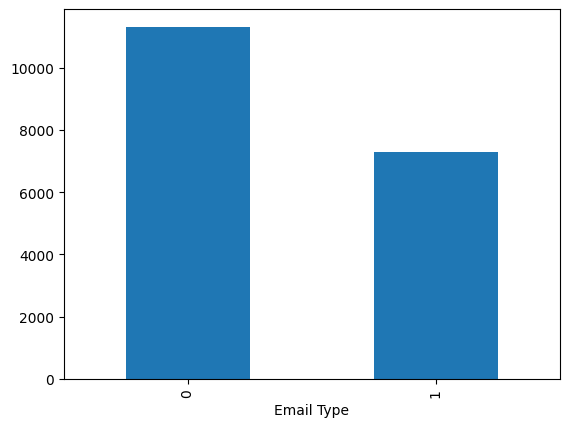

In [ ]:
# To visualize the distribution of email types

data['Email Type'].value_counts().plot(kind="bar")

In [ ]:
# Split the data into phishing and safe emails

data_safe=data[data['Email Type']==0]
data_phising=data[data['Email Type']==1]

In [ ]:
# To check the shape of the phishing emails data

pd.set_option('display.float_format', lambda x: '%.3f' % x) #Standard number format

In [ ]:
# To describe the phishing emails data

data_phising['length'] = data_phising['Email Text'].apply(lambda x: len(str(x)))
data_phising["length"].describe()

count    7310.000
mean     1422.157
std      2724.254
min         0.000
25%       313.000
50%       636.000
75%      1371.000
max     70090.000
Name: length, dtype: float64

In [ ]:
# To describe the safe emails data

data_safe['length'] =data_safe['Email Text'].apply(lambda x: len(str(x)))
data_safe["length"].describe()

count    11319.000
mean      1721.415
std       4076.578
min          0.000
25%        372.000
50%        829.000
75%       1754.000
max     110624.000
Name: length, dtype: float64

# Boxplot, Histogram and Violin plot of the data

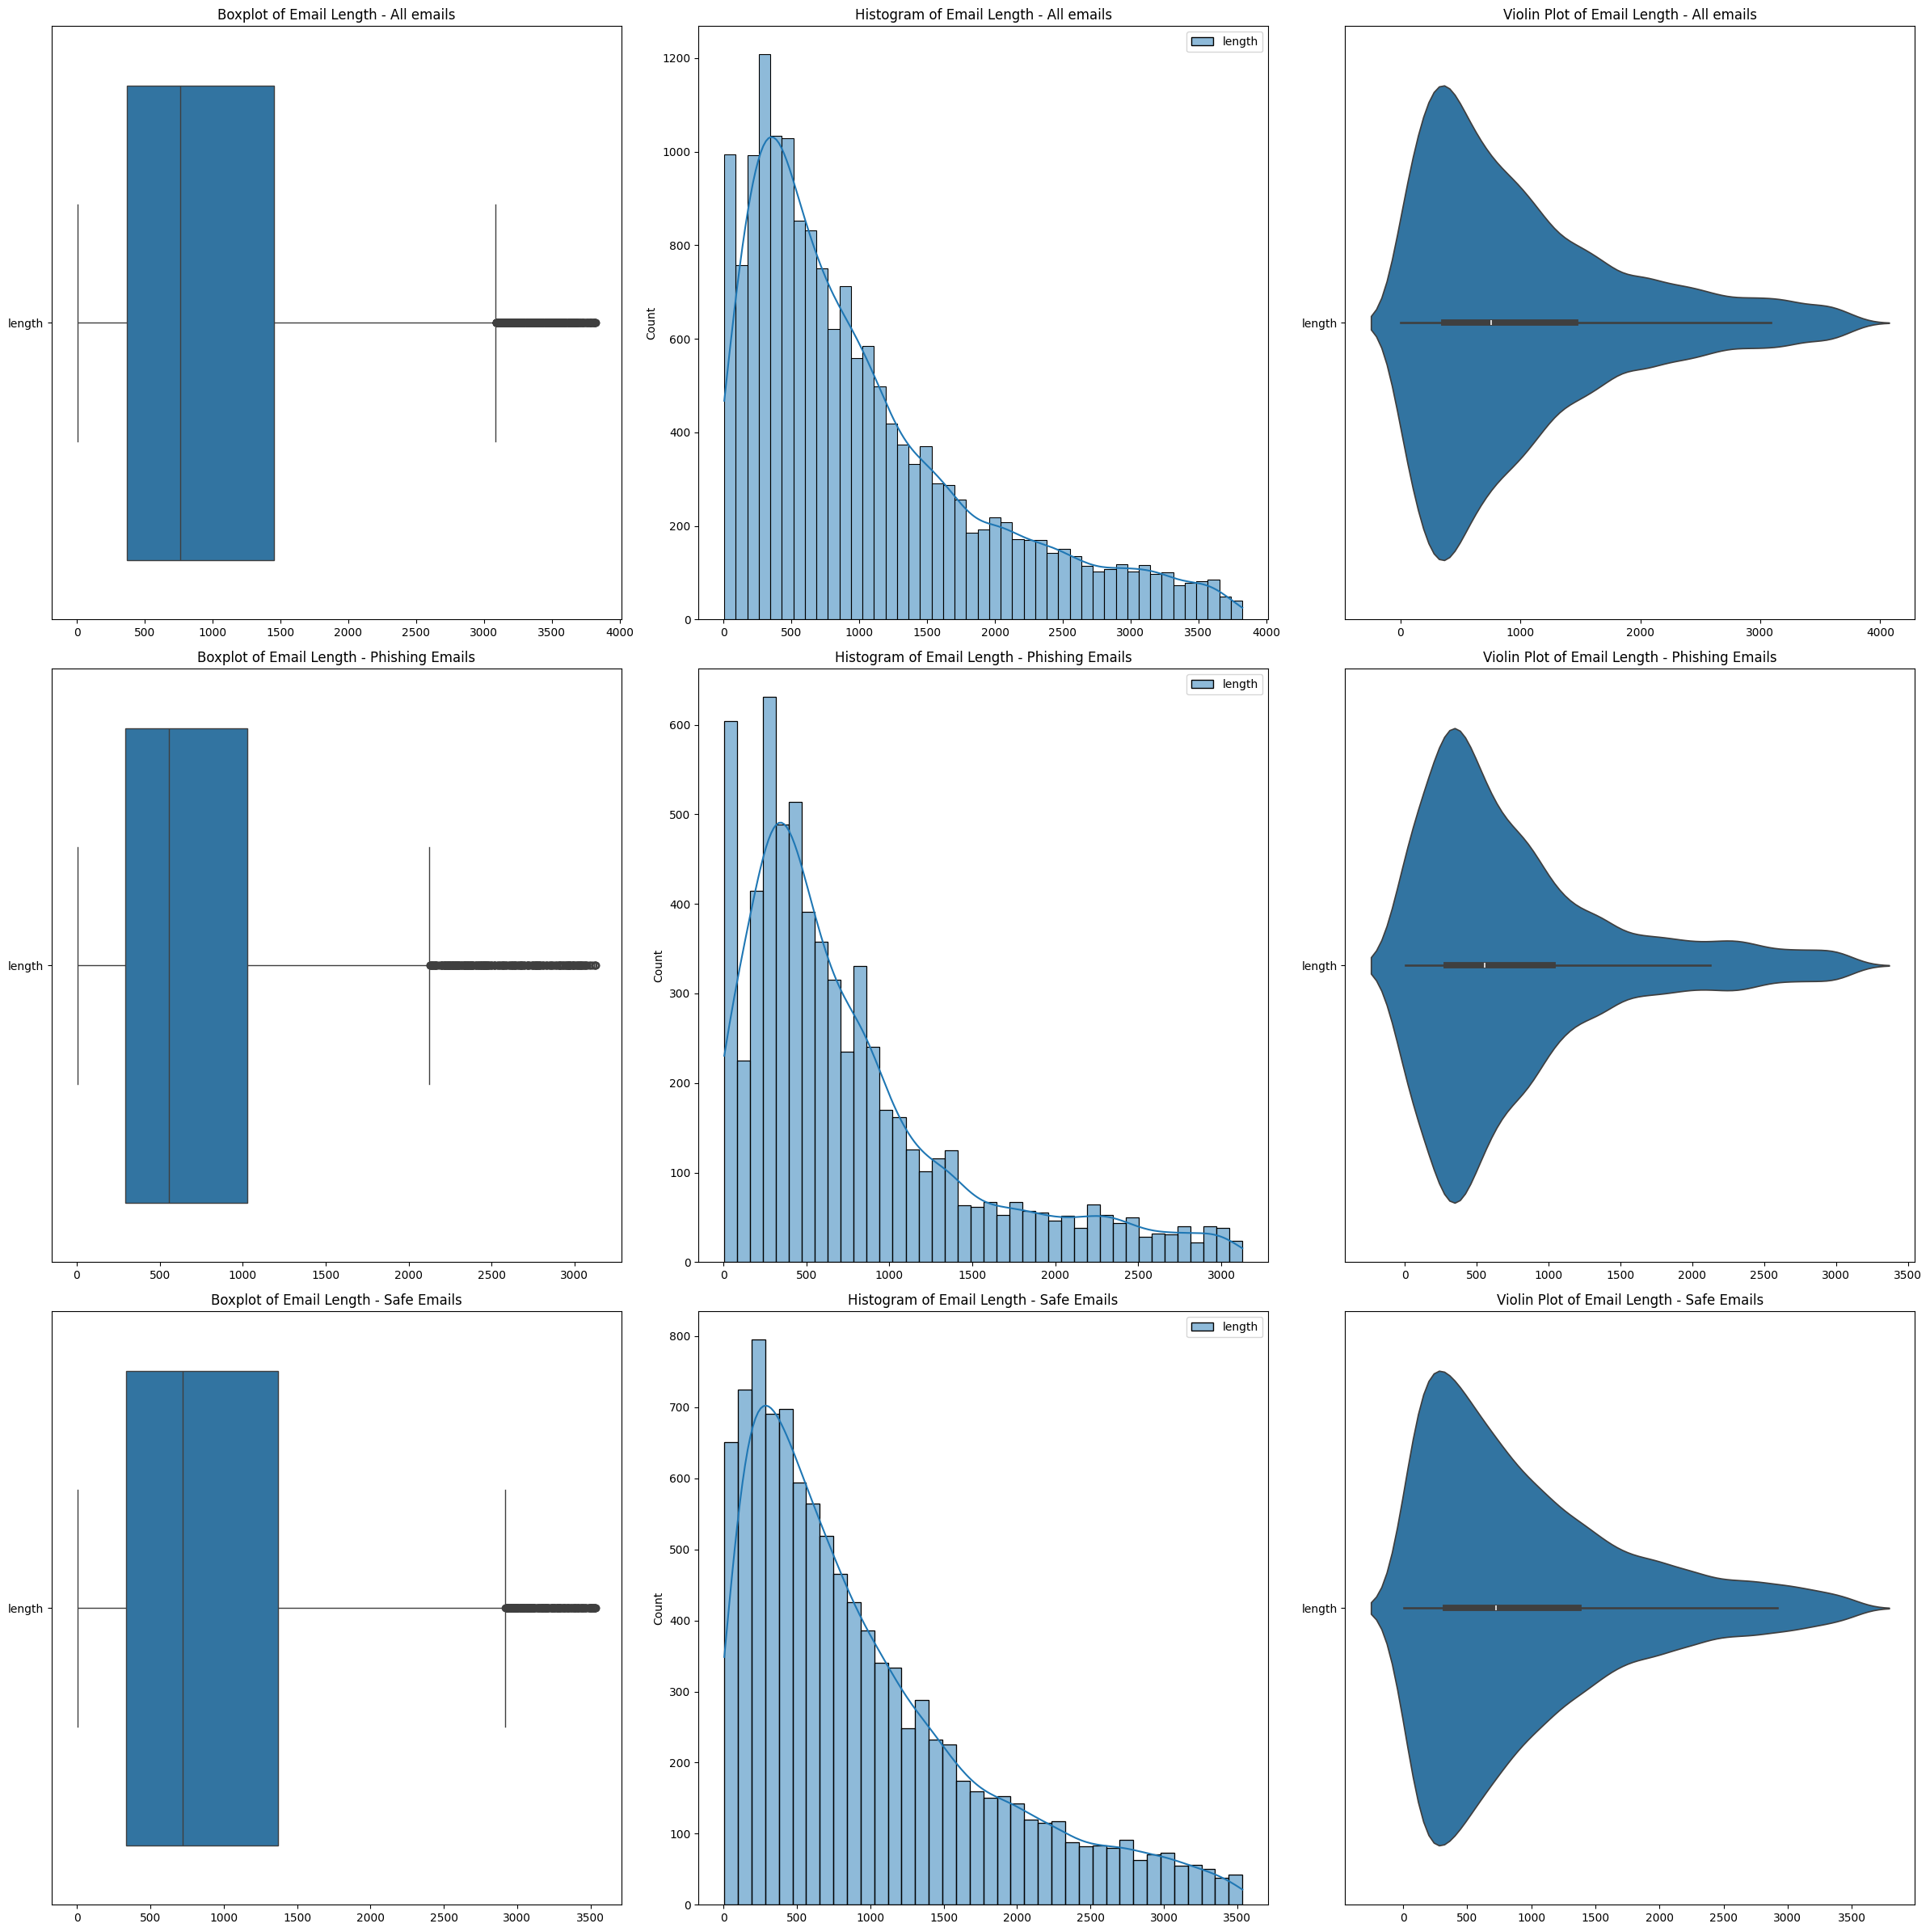

In [50]:
# Define the lower and upper bounds based on percentiles
lower_bound = data['length'].quantile(0.01)  # 1st percentile
upper_bound = data['length'].quantile(0.9)  # 90th percentile

# Filter the DataFrame to remove outliers
filtered_data = data[(data['length'] >= lower_bound) & (data['length'] <= upper_bound)]

# Length DataFrame after removing outliers
length = pd.DataFrame(filtered_data["length"])

# Create subplots
fig, axes = plt.subplots(3, 3, figsize=(24, 24))

for i, (data_subset, title) in enumerate(zip([data, data_phising, data_safe], ['All emails', 'Phishing Emails', 'Safe Emails'])):
    # Define the lower and upper bounds based on percentiles
    lower_bound = data_subset['length'].quantile(0.01)  # 1st percentile
    upper_bound = data_subset['length'].quantile(0.9)  # 90th percentile

    # Filter the DataFrame to remove outliers
    filtered_data = data_subset[(data_subset['length'] >= lower_bound) & (data_subset['length'] <= upper_bound)]

    # Length DataFrame after removing outliers
    length = pd.DataFrame(filtered_data["length"])

    # Boxplot
    sb.boxplot(data=length, orient="h", ax=axes[i, 0])
    axes[i, 0].set_title(f'Boxplot of Email Length - {title}')

    # Histogram
    sb.histplot(data=length, kde=True, ax=axes[i, 1])
    axes[i, 1].set_title(f'Histogram of Email Length - {title}')

    # Violin plot
    sb.violinplot(data=length, orient="h", ax=axes[i, 2])
    axes[i, 2].set_title(f'Violin Plot of Email Length - {title}')

plt.tight_layout()
plt.show()

# For Safe Emails

In [ ]:
# We individually create wordclouds for each type of email to find out the most commonly words

# We split the dataset into two, safe emails and phishing emails

all_mails_sf = " ".join(data_safe['Email Text'])

# Word Cloud Visualization for the data based on frequency of each word

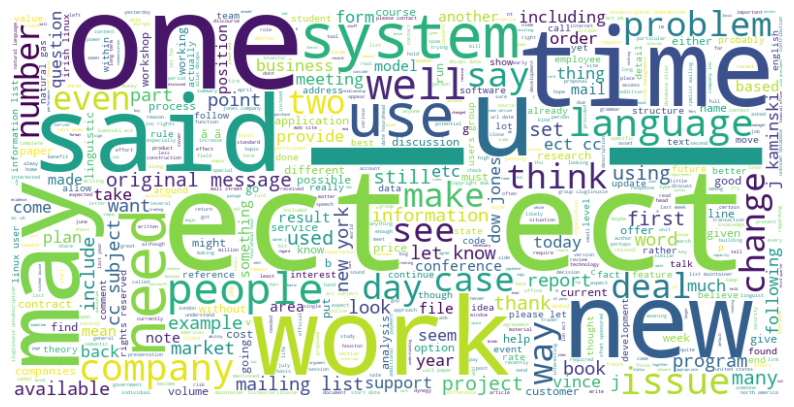

In [ ]:
# Word Cloud Visualization for the data based on frequency of each word
punkt_path = "C:/nltk_data/tokenizers/punkt/english.pickle"

with open(punkt_path, "rb") as f:
    sentence_tokenizer = pickle.load(f)

# ---- Load word tokenizer from treebank manually ----

word_tokenizer = TreebankWordTokenizer()

#We use this instead of word_tokenize() (which depends on auto-loaded models) to avoid LookupError.

# ---- Load English stopwords manually ----
stopwords_path = "C:/nltk_data/corpora/stopwords/english"
with open(stopwords_path, "r", encoding="utf8") as f:
    stop_words = set(f.read().splitlines())

# ---- Sample Text or Your Combined Email Text ----
#all_mails_sf = "This is a sample phishing email. It contains spam messages and fake links! Click here to update your password."

# ---- Tokenize into words ----
tokens = word_tokenizer.tokenize(all_mails_sf)

# ---- Remove stopwords ----
filtered_tokens = [word for word in tokens if word.lower() not in stop_words and re.match(r'\w+', word)]

# ---- Create WordCloud ----
word_cloud = WordCloud(width=800, height=400, background_color='white', max_words=10000).generate(" ".join(filtered_tokens))

# ---- Show WordCloud ----
plt.figure(figsize=(10, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()


 # For phising emails

In [ ]:
# We individually create wordclouds for each type of email to find out the most commonly words

# We split the dataset into two, safe emails and phishing emails

all_mails_ph = " ".join(data_phising['Email Text'])

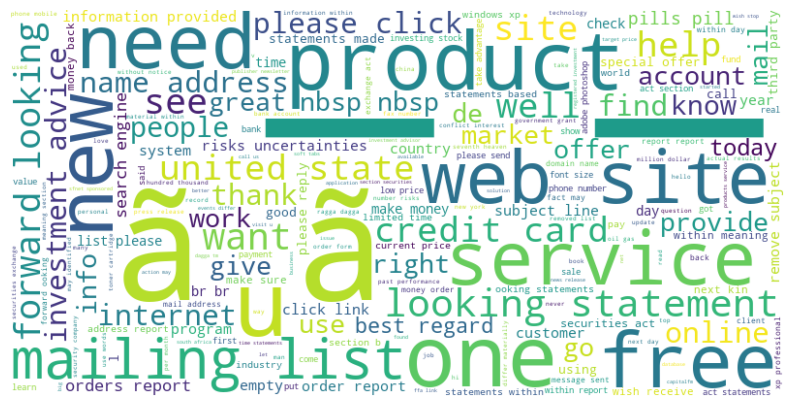

In [ ]:
 #---- Load Punkt tokenizer manually ----

punkt_path = "C:/nltk_data/tokenizers/punkt/english.pickle"

with open(punkt_path, "rb") as f:
    sentence_tokenizer = pickle.load(f)

# ---- Load word tokenizer from treebank manually ----

word_tokenizer = TreebankWordTokenizer()
#We use this instead of word_tokenize() (which depends on auto-loaded models) to avoid LookupError.

# ---- Load English stopwords manually ----
stopwords_path = "C:/nltk_data/corpora/stopwords/english"
with open(stopwords_path, "r", encoding="utf8") as f:
    stop_words = set(f.read().splitlines())

# ---- Sample Text or Your Combined Email Text ----
#all_mails_sf = "This is a sample phishing email. It contains spam messages and fake links! Click here to update your password."

# ---- Tokenize into words ----
tokens = word_tokenizer.tokenize(all_mails_ph)

# ---- Remove stopwords ----
filtered_tokens = [word for word in tokens if word.lower() not in stop_words and re.match(r'\w+', word)]

# ---- Create WordCloud ----
word_cloud = WordCloud(width=800, height=400, background_color='white', max_words=10000).generate(" ".join(filtered_tokens))

# ---- Show WordCloud ----
plt.figure(figsize=(10, 6))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Tokenization

In [ ]:
# Tokenization function to convert text into sequences of integers
def Tokenize(column, seq_len):
    stop_words = set(stopwords.words('english'))
    stop_words |= {'_'}  # Add underscore to stop words
    stop_words |= {str(i) for i in range(10)}
    stop_words.add('e')
    stop_words.add('20')
    # Create a list to store the filtered words
    filtered_corpus = []
    for text in column:
        filtered_words = [word for word in text.split() if word.lower() not in stop_words]
        filtered_corpus.extend(filtered_words)

    count_words = Counter(filtered_corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split() if word.lower() not in stop_words]
        text_int.append(r)

    features = np.zeros((len(text_int), seq_len), dtype=int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[:seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADLIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# To visualize the Word Count vs Word

In [ ]:
# Here We can see that phishing emails use deceiving words such as “free”, “busniess”,”company”,etc. and promoting words such as “click”, “order” and “make”.
emails = ["Safe Emails", "Phishing Emails"]

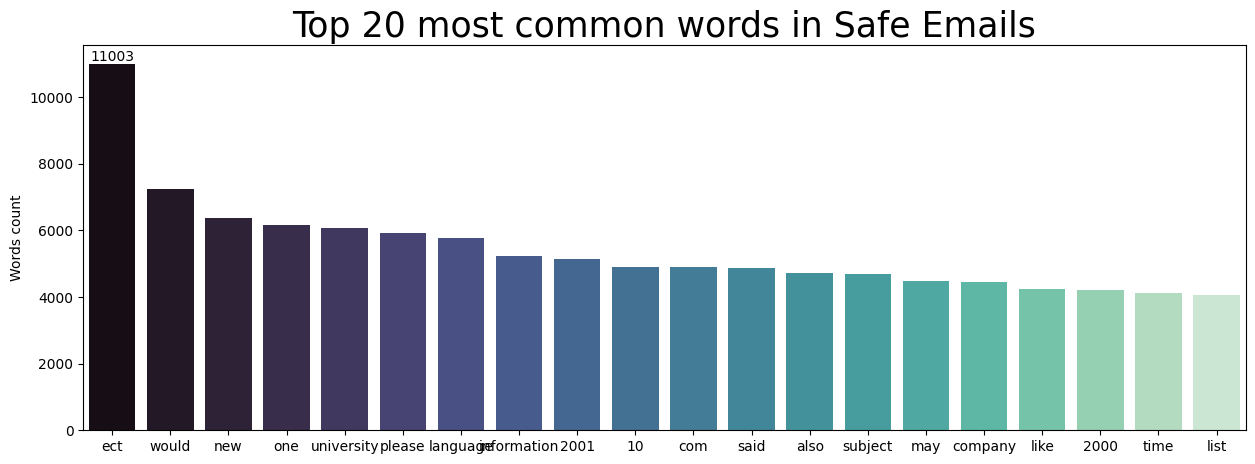

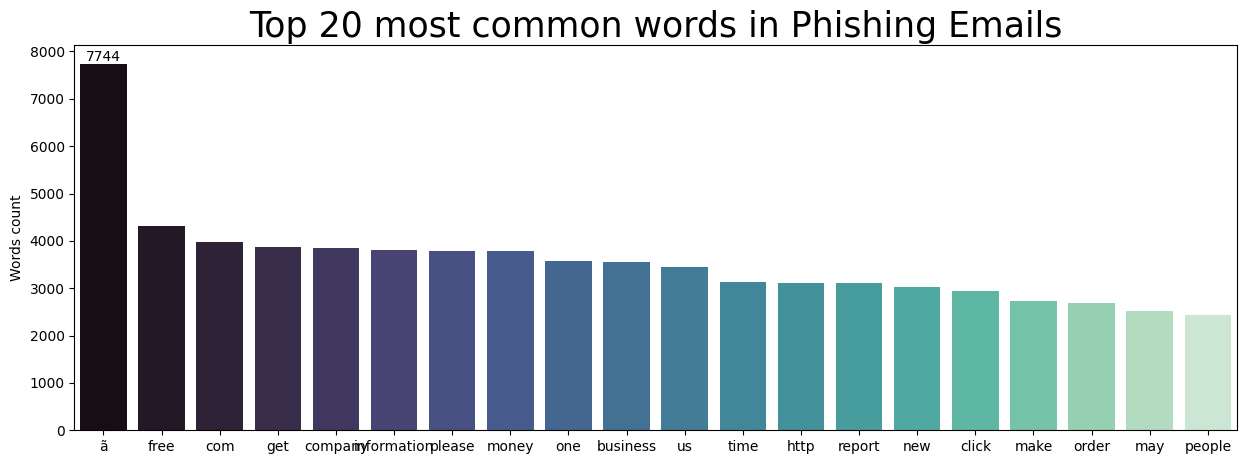

In [ ]:
# Using for loops to visualize the Word Count vs Word

for i in range(0,2):
    vocabulary, tokenized_column = Tokenize(data[data["Email Type"] == i]["Email Text"], 300)
    keys = []
    values = []
    for key, value in vocabulary[:20]:
        keys.append(key)
        values.append(value)
    plt.figure(figsize=(15, 5))
    ax = sb.barplot(x=keys,y=values, palette='mako')
    plt.title(f'Top 20 most common words in {emails[i]}', size=25)
    ax.bar_label(ax.containers[0])
    plt.ylabel("Words count")
    plt.show()

# Sentiment Analysis

In [ ]:
# Sample email texts (replace with your actual email texts)

# Assuming "Email Text" is the column name containing email texts for phishing emails
phishing_emails = data_phising["Email Text"].tolist()  

# Assuming "Email Text" is the column name containing email texts for safe emails
safe_emails = data_safe["Email Text"].tolist()  

# Function to perform sentiment analysis and return DataFrame
def analyze_sentiment(emails):
    sentiments = []
    for email in emails:
        blob = TextBlob(email)
        # Get the absolute value of sentiment polarity
        sentiment_score = abs(blob.sentiment.polarity)  
        sentiments.append(sentiment_score)
    return pd.DataFrame({"Sentiment_Score": sentiments})

# Analyze sentiment for phishing and safe emails
phishing_sentiments_df = analyze_sentiment(phishing_emails)
safe_sentiments_df = analyze_sentiment(safe_emails)

# Add sentiment scores as new columns in the original datasets
data_phising["Sentiment_Score"] = phishing_sentiments_df
data_safe["Sentiment_Score"] = safe_sentiments_df

# Print average sentiment scores 
print("Average sentiment score for phishing emails:", phishing_sentiments_df["Sentiment_Score"].mean())
print("Average sentiment score for safe emails:", safe_sentiments_df["Sentiment_Score"].mean())

# Optionally, concatenate phishing and safe email dataframes if needed
data_combined = pd.concat([data_phising, data_safe], ignore_index=True)

Average sentiment score for phishing emails: 0.18785537604648103
Average sentiment score for safe emails: 0.1199664368630515


In [ ]:
# To drop the rows with NaN values in 'Sentiment_Score'

data_combined
data_combined.dropna(subset=['Sentiment_Score'], inplace=True)

# Histogram for Phishing Emails vs Safe Emails

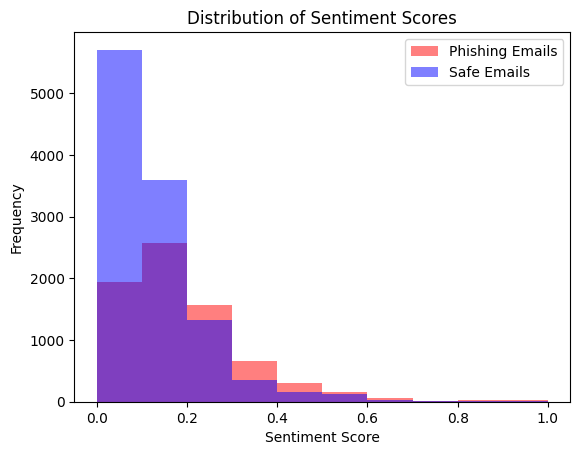

In [79]:
# Histogram for Phishing Emails
plt.hist(phishing_sentiments_df["Sentiment_Score"], bins=10, color='red', alpha=0.5, label='Phishing Emails')
# Histogram for Safe Emails
plt.hist(safe_sentiments_df["Sentiment_Score"], bins=10, color='blue', alpha=0.5, label='Safe Emails')

plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# model training

In [ ]:
# Prepare data for model training

x = data['Email Text']
y,class_names = pd.factorize(data['Email Type'],sort=True)

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25)

x_train = [str(x) for x in x_train]
x_test  = [str(x) for x in x_test]

In [ ]:

def DL_Classifier(model, x_train, y_train, x_test, y_test, label_encoder):
    # Get predicted probabilities and convert to label indices
    y_train_pred_probs = model.predict(x_train)
    y_test_pred_probs = model.predict(x_test)

    y_train_pred = np.argmax(y_train_pred_probs, axis=1)
    y_test_pred = np.argmax(y_test_pred_probs, axis=1)

    # Decode labels back to string if label_encoder provided
    if label_encoder:
        y_train_decoded = label_encoder.inverse_transform(y_train)
        y_train_pred_decoded = label_encoder.inverse_transform(y_train_pred)

        y_test_decoded = label_encoder.inverse_transform(y_test)
        y_test_pred_decoded = label_encoder.inverse_transform(y_test_pred)

        class_names = label_encoder.classes_
    else:
        y_train_decoded = y_train
        y_train_pred_decoded = y_train_pred
        y_test_decoded = y_test
        y_test_pred_decoded = y_test_pred
        class_names = ['safe', 'phishing']

    # Accuracy
    print('Training Accuracy: {:.3f}'.format(accuracy_score(y_train_decoded, y_train_pred_decoded)))
    print('Test Accuracy: {:.3f}'.format(accuracy_score(y_test_decoded, y_test_pred_decoded)))

    # Classification Reports
    print("\nTraining Classification Report:\n", classification_report(y_train_decoded, y_train_pred_decoded))
    print("\nTest Classification Report:\n", classification_report(y_test_decoded, y_test_pred_decoded))

    # Confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    train_conf_matrix = confusion_matrix(y_train_decoded, y_train_pred_decoded)
    test_conf_matrix = confusion_matrix(y_test_decoded, y_test_pred_decoded)

    sb.heatmap(train_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicted', fontsize=14)
    axes[0].set_ylabel('True', fontsize=14)
    axes[0].set_title('Training Confusion Matrix', fontsize=16)

    sb.heatmap(test_conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicted', fontsize=14)
    axes[1].set_ylabel('True', fontsize=14)
    axes[1].set_title('Test Confusion Matrix', fontsize=16)

    plt.tight_layout()
    plt.show()


# GRU model

# Model Building and Fitting

In [ ]:
# Encode the labels

label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Email Type'])

# Preprocess the data
tokenizer_GRUU = Tokenizer()
tokenizer_GRUU.fit_on_texts(data['Email Text'])
X = tokenizer_GRUU.texts_to_sequences(data['Email Text'])

# Set maximum sequence length
max_seq_length = 150  # Adjust as needed based on your data and memory constraints
X = pad_sequences(X, maxlen=max_seq_length)

y = np.array(data['Label'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build the GRU model
model_GRUU = Sequential()
model_GRUU.add(Embedding(input_dim=len(tokenizer_GRUU.word_index) + 1, output_dim=100))
model_GRUU.add(GRU(128))
model_GRUU.add(Dense(1, activation='sigmoid'))

# Compile the model with binary_crossentropy loss for binary classification
model_GRUU.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
blah = model_GRUU.fit(X_train, y_train, epochs=15, batch_size=50, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model_GRUU.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 73s 234ms/step - accuracy: 0.7537 - loss: 0.5284 - val_accuracy: 0.9452 - val_loss: 0.1375
Epoch 2/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 226ms/step - accuracy: 0.9673 - loss: 0.0766 - val_accuracy: 0.9557 - val_loss: 0.1137
Epoch 3/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 68s 229ms/step - accuracy: 0.9820 - loss: 0.0473 - val_accuracy: 0.9603 - val_loss: 0.1063
Epoch 4/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 226ms/step - accuracy: 0.9853 - loss: 0.0263 - val_accuracy: 0.9622 - val_loss: 0.1248
Epoch 5/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 226ms/step - accuracy: 0.9874 - loss: 0.0225 - val_accuracy: 0.8959 - val_loss: 0.2435
Epoch 6/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 225ms/step - accuracy: 0.9828 - loss: 0.0449 - val_accuracy: 0.9512 - val_loss: 0.1292
Epoch 7/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 223ms/step - accuracy: 0.9866 - loss: 0.0226 - val_accuracy: 0.9603 - val_loss: 0.1361
Epoch 8/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 67s 224ms/step - accuracy: 0.9894 - loss: 0

In [ ]:
# To view the model summary

model_GRUU.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 100)       │    17,613,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        88,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,104,349 (202.58 MB)

 Trainable params: 17,701,449 (67.53 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,402,900 (135.05 MB)

# Visualize the traing and validation loss

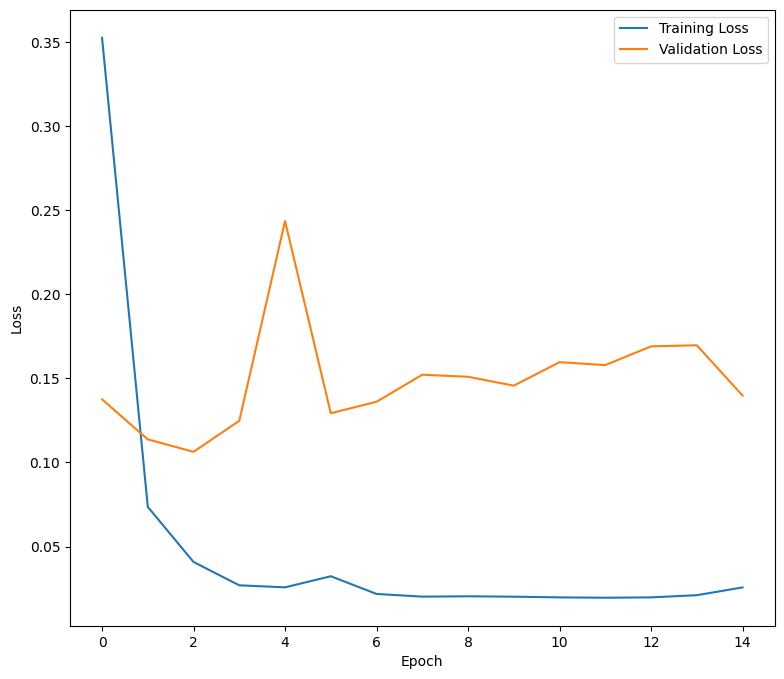

In [85]:
# Plot training and validation loss/accuracy
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.plot(blah.history['loss'], label='Training Loss')
plt.plot(blah.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


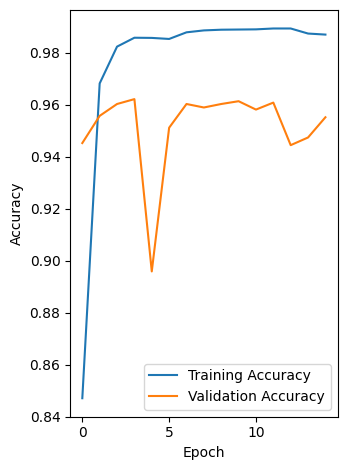

In [ ]:
# Plot training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(blah.history['accuracy'], label='Training Accuracy')
plt.plot(blah.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Model Evaluation

In [87]:
# Evaluate the model
loss, accuracy = model_GRUU.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred = model_GRUU.predict(X_test)
y_pred_binary = (y_pred > 0.5).astype(int)

117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.9521 - loss: 0.1448
Test Loss: 0.1397, Test Accuracy: 0.9552
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


# Classification Report

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      2256
           1       0.93      0.96      0.94      1470

    accuracy                           0.96      3726
   macro avg       0.95      0.96      0.95      3726
weighted avg       0.96      0.96      0.96      3726



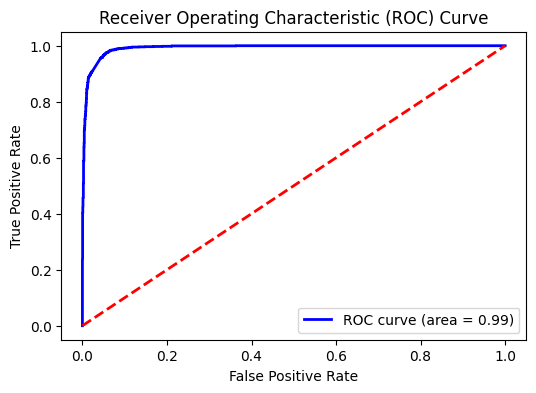

In [88]:
# Classification Report
from sklearn.metrics import roc_curve, auc
print(classification_report(y_test, y_pred_binary))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix

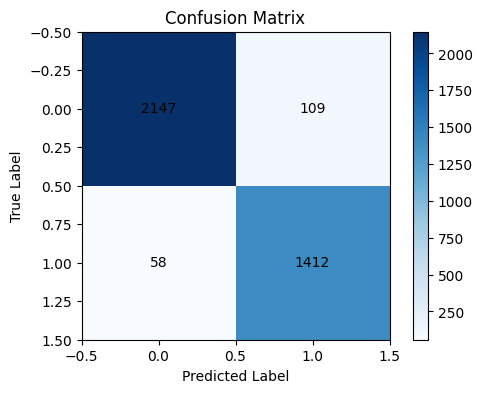

In [89]:

# Assuming y_test and y_pred_binary are defined
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# Plotting the confusion matrix with annotated numbers
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# Add numerical values to the matrix cells
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Model Building of BiLSTM

In [ ]:
# # --------------------------------------------------
# # 1. Load and Clean Dataset
# # --------------------------------------------------
# #data = pd.read_csv("emails.csv")  # <-- Change filename if needed
data.dropna(subset=["Email Text", "Email Type"], inplace=True)


data['Clean Text'] = data['Email Text'].apply(preprocess_text)

# --------------------------------------------------
# 2. Label Encoding (1 = Phishing, 0 = Safe)
# --------------------------------------------------
label_encoder= LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Email Type'])

# 3. Save LabelEncoder

joblib.dump(label_encoder, "label_encoder.pkl")

# # --------------------------------------------------
# 4. Tokenization
# # --------------------------------------------------
tokenizer_bilstm = Tokenizer(oov_token="<OOV>")
tokenizer_bilstm.fit_on_texts(data['Clean Text'])

#5. Save Tokenizer
with open("tokenizer_bilstm.pkl", "wb") as f:
    pickle.dump(tokenizer_bilstm, f)

# # --------------------------------------------------
# 6. Convert Texts to Sequences and Pad
# # --------------------------------------------------
MAX_LEN = 300
X = tokenizer_bilstm.texts_to_sequences(data['Clean Text'])
X = pad_sequences(X, maxlen=MAX_LEN, padding='post')
y = np.array(data['Label'])

# # --------------------------------------------------
# 7. Train-Test Split
# # --------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# # --------------------------------------------------
# 8. Handle Class Imbalance
# # --------------------------------------------------
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weight_dict = dict(enumerate(class_weights))

# # --------------------------------------------------
# 9. Build the BiLSTM Model
# # --------------------------------------------------
model_bilstm = Sequential()
model_bilstm.add(Embedding(input_dim=len(tokenizer_bilstm.word_index) + 1,
                           output_dim=100,
                           input_length=MAX_LEN))
model_bilstm.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model_bilstm.add(Dense(1, activation='sigmoid'))

model_bilstm.compile(optimizer='adam',
                     loss='binary_crossentropy',
                     metrics=['accuracy'])

# # --------------------------------------------------
# 10. Train the Model
# # --------------------------------------------------
# early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model_bilstm.fit(
    X_train, y_train,
    epochs=15,
    batch_size=50,
    validation_data=(X_test, y_test),
    class_weight=class_weight_dict,
    #callbacks=[early_stop],
    verbose=1
)

# # --------------------------------------------------
# 11. Evaluate the Model
# # --------------------------------------------------
loss, acc = model_bilstm.evaluate(X_test, y_test)
print(f"\n✅ Test Accuracy: {acc:.4f}")

# --------------------------------------------------
# 12. Save the Model
# --------------------------------------------------
model_bilstm.save("model_bilstm.h5")
print("✅ BiLSTM model saved as model_bilstm.h5")



Epoch 1/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 430s 1s/step - accuracy: 0.7945 - loss: 0.4201 - val_accuracy: 0.9474 - val_loss: 0.1469
Epoch 2/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 670s 2s/step - accuracy: 0.9759 - loss: 0.0668 - val_accuracy: 0.9662 - val_loss: 0.1024
Epoch 3/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 2548s 8s/step - accuracy: 0.9815 - loss: 0.0423 - val_accuracy: 0.9651 - val_loss: 0.1107
Epoch 4/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 582s 2s/step - accuracy: 0.9871 - loss: 0.0285 - val_accuracy: 0.9442 - val_loss: 0.1556
Epoch 5/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 578s 2s/step - accuracy: 0.9855 - loss: 0.0296 - val_accuracy: 0.9549 - val_loss: 0.1432
Epoch 6/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 537s 2s/step - accuracy: 0.9892 - loss: 0.0226 - val_accuracy: 0.9656 - val_loss: 0.1355
Epoch 7/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.9840 - loss: 0.0352 - val_accuracy: 0.9546 - val_loss: 0.1500
Epoch 8/15
299/299 ━━━━━━━━━━━━━━━━━━━━ 675s 2s/step - accuracy: 0.9891 - loss: 0.0225 - val_acc


✅ Test Accuracy: 0.9549
✅ BiLSTM model saved as model_bilstm.h5


In [ ]:
# To view the model summary of BiLSTM

model_bilstm .summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 300, 100)       │    17,612,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 256)            │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,540,261 (204.24 MB)

 Trainable params: 17,846,753 (68.08 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 35,693,508 (136.16 MB)

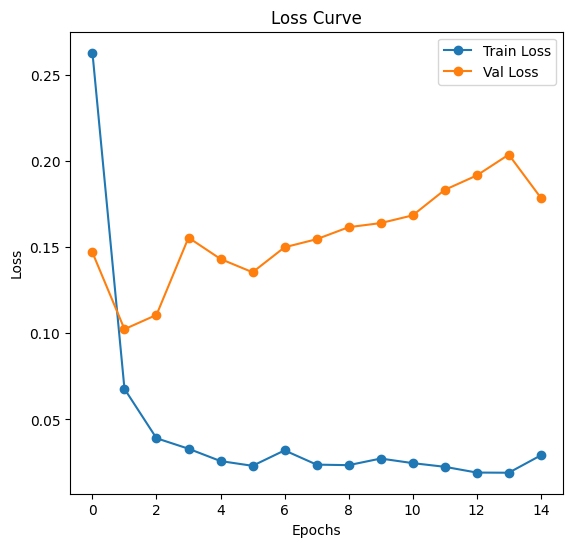

In [ ]:
# Plot training and validation loss curve


plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
 

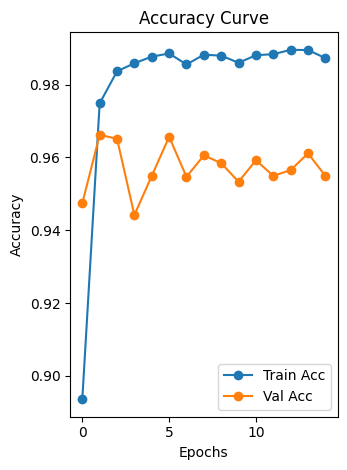

In [ ]:
# Plot training and validation accuracy curve

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Acc', marker='o')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model_bilstm.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

# Generate predictions
y_pred = model_bilstm.predict(X_test)
y_pred_binary = (y_pred > 0.7).astype(int)

117/117 ━━━━━━━━━━━━━━━━━━━━ 14s 118ms/step - accuracy: 0.9519 - loss: 0.1864
Test Loss: 0.1787, Test Accuracy: 0.9549
117/117 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step


# Classification Report


Classification Report:
              precision    recall  f1-score   support

    Phishing       0.96      0.96      0.96      2256
        Safe       0.94      0.94      0.94      1470

    accuracy                           0.95      3726
   macro avg       0.95      0.95      0.95      3726
weighted avg       0.95      0.95      0.95      3726



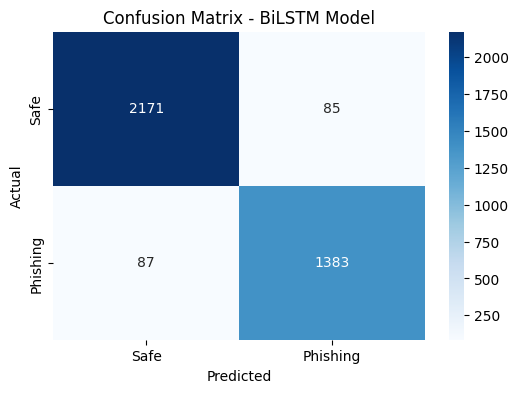

In [ ]:
# Print classification report

print("\nClassification Report:")
print(classification_report(y_test, y_pred_binary, target_names=["Phishing","Safe"]))


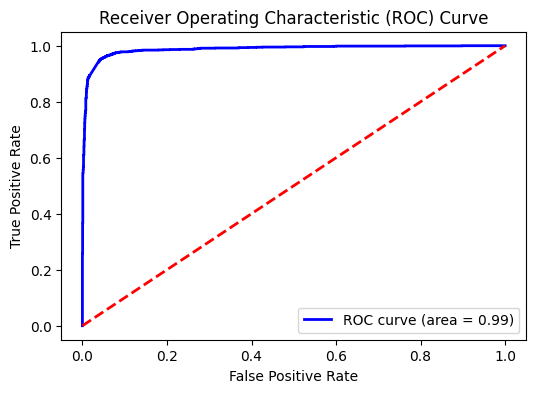

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Confusion Matrix

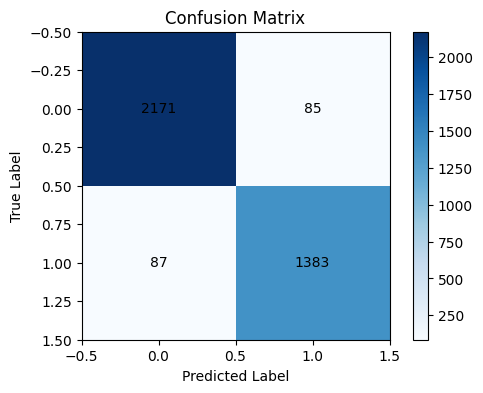

In [98]:

# # Assuming y_test and y_pred_binary are defined
conf_matrix = confusion_matrix(y_test, y_pred_binary)

# # Plotting the confusion matrix with annotated numbers
plt.figure(figsize=(6, 4))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')

# # Add numerical values to the matrix cells
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# To save the  BiLSTM ,Tokerinzer and Label encoder model

In [ ]:
# # -----------------------------
# # Load the Model & Tokenizer
# # -----------------------------
model = tf.keras.models.load_model("model_bilstm.h5")

with open("tokenizer_bilstm.pkl", "rb") as f:
    tokenizer = pickle.load(f)


In [ ]:
# To view the evaluation metrics of the both the model

results = {
    "Model": ["BiLSTM", "GRU"],
    "Accuracy": [ 0.93, 0.90 ],
    "Precision": [0.92, 0.89],
    "Recall": [0.94, 0.90],
    "F1-score": [0.93, 0.89]
}

import pandas as pd
df_results = pd.DataFrame(results)
print(df_results)


    Model  Accuracy  Precision  Recall  F1-score
0  BiLSTM     0.930      0.920   0.940     0.930
1     GRU     0.900      0.890   0.900     0.890


#  Plot Comparison (Accuracy & F1-Score)

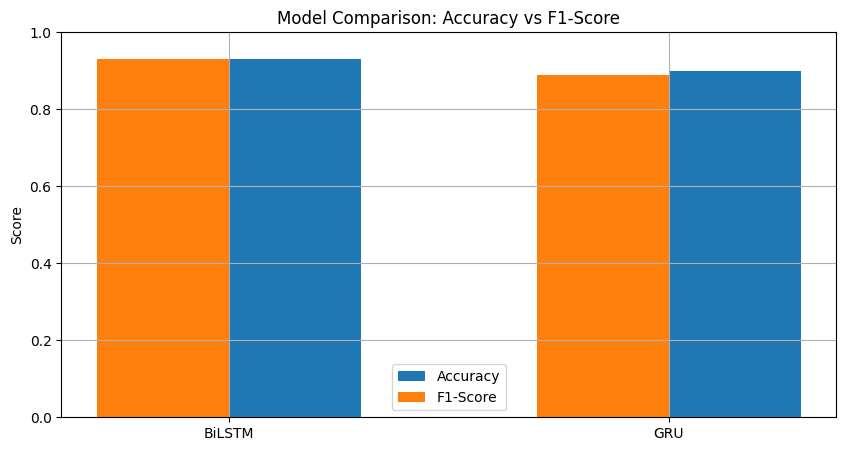

In [ ]:
# Plotting the comparison of models using bar charts for Accuracy and F1-Score

plt.figure(figsize=(10,5))
x = df_results['Model']
acc = df_results['Accuracy']
f1 = df_results['F1-score']

plt.bar(x, acc, width=0.3, label='Accuracy', align='edge')
plt.bar(x, f1, width=-0.3, label='F1-Score', align='edge')
plt.ylabel("Score")
plt.title("Model Comparison: Accuracy vs F1-Score")
plt.legend()
plt.ylim(0, 1)
plt.grid(True)
plt.show()


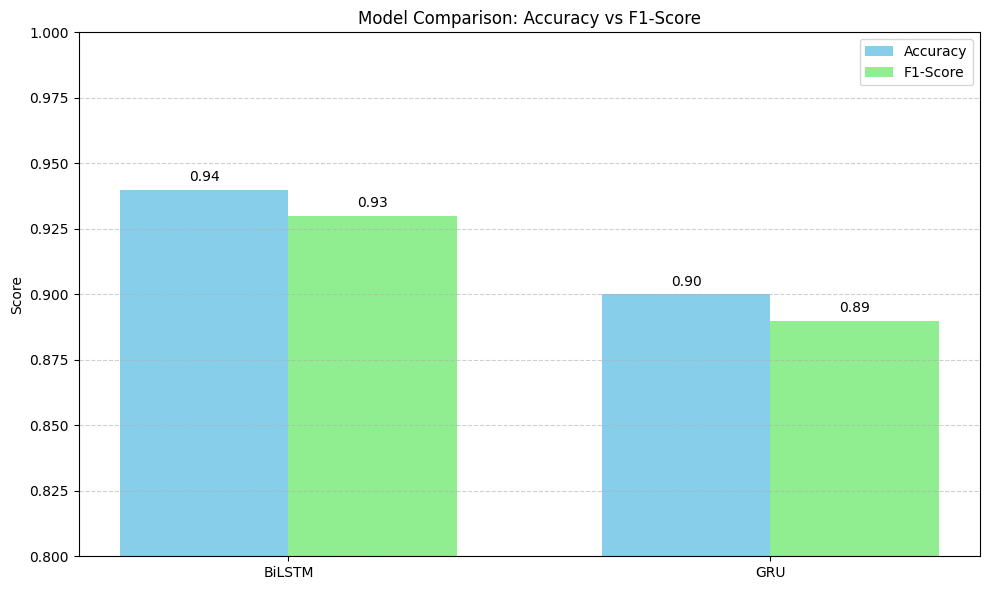

In [ ]:
# Data
# Assuming you have two models and their respective accuracy and F1-scores


models = ['BiLSTM', 'GRU']
accuracy = [ 0.94, 0.90]
f1_score = [ 0.93, 0.89]


x = np.arange(len(models))
width = 0.35

plt.figure(figsize=(10, 6))
bars1 = plt.bar(x - width/2, accuracy, width, label='Accuracy', color='skyblue')
bars2 = plt.bar(x + width/2, f1_score, width, label='F1-Score', color='lightgreen')

# Add value annotations
for bar in bars1:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{bar.get_height():.2f}', 
             ha='center', va='bottom')
for bar in bars2:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.002, f'{bar.get_height():.2f}', 
             ha='center', va='bottom')

# # Labels and settings
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs F1-Score')
plt.xticks(x, models)
plt.ylim(0.80, 1.00)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Saving Models & Tokenizers

In [ ]:
# Save Models of gru

model_GRUU.save("model_gru.h5")

# Save Tokenizers

with open("tokenizer_gru.pkl", "wb") as f:
    pickle.dump(tokenizer_GRUU, f)

In [ ]:

# Label encoder 

label_encoder = LabelEncoder()
data['Label'] = label_encoder.fit_transform(data['Email Type'])  # Assumes 'Email Type' has 'phishing'/'safe'

# Save it for later use
joblib.dump(label_encoder, 'label_encoder.pkl')


['label_encoder.pkl']

#  Loading Models & Tokenizers Later

In [ ]:
# Save the model and tokenizer for later use
# Save the label encoder if used for inverse transformation
label_encoder = LabelEncoder()
label_encoder.fit(["phishing","safe"]) 
joblib.dump(label_encoder, 'label_encoder.pkl')

# Later on, to load the model and tokenizer:
model_gru_loaded = load_model("model_gru.h5")

with open("tokenizer_gru.pkl", "rb") as f_tok:
    tokenizer_gru_loaded = pickle.load(f_tok)

label_encoder_loaded = joblib.load('label_encoder.pkl')


In [ ]:
# Before label Encoding

# Output should be: ['safe', 'phishing']

print(label_encoder.classes_)  

['phishing' 'safe']


In [ ]:
# After label Encoding

# Output should be: [0, 1]

print(label_encoder.transform(['phishing', 'safe']))

[0 1]
